In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from numpy import genfromtxt

In [ ]:
data = genfromtxt('fer2013.csv', delimiter=',', dtype=str)
trainingX = []
trainingY = []
testingX = []
testingY = []
for i in range(1,len(data)):
  if(data[i][2] == 'Training'):
    tmp = [0,0,0,0,0,0,0]
    tmp[int(data[i][0])] = 1
    trainingY.append(tmp)
    tmp = np.reshape(data[i][1].split(), (48,48))
    tmpArr = []
    for x in range(48):
      aks = []
      for y in range(48):
        aks.append(float(tmp[x][y]))
      tmpArr.append(aks)
    trainingX.append([tmpArr])
  else:
    tmp = [0,0,0,0,0,0,0]
    tmp[int(data[i][0])] = 1
    testingY.append(tmp)
    tmp = np.reshape(data[i][1].split(), (48,48))
    tmpArr = []
    for x in range(48):
      aks = []
      for y in range(48):
        aks.append(float(tmp[x][y]))
      tmpArr.append(aks)
    testingX.append([tmpArr])


In [ ]:
trainingX = np.array(trainingX)
testingX = np.array(testingX)
trainingY = np.array(trainingY)
testingY = np.array(testingY)
valX = trainingX[0:4000]
valY = trainingY[0:4000]
trainingX = trainingX[4000:]
trainingY = trainingY[4000:]

In [ ]:
trainingX = torch.tensor(trainingX, requires_grad=False).double()
trainingY = torch.tensor(trainingY, requires_grad=False).double()
testingX = torch.tensor(testingX, requires_grad=False).double()
testingY = torch.tensor(testingY, requires_grad=False).double()
valX = torch.tensor(valX, requires_grad=False).double()
valY = torch.tensor(valY, requires_grad=False).double()

In [ ]:
print(trainingX.shape)
print(trainingY.shape)
print(testingX.shape)
print(testingY.shape)

torch.Size([24709, 1, 48, 48])
torch.Size([24709, 7])
torch.Size([7178, 1, 48, 48])
torch.Size([7178, 7])


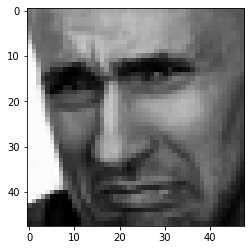

In [ ]:
import matplotlib.pyplot as plt
for i in range(5):
  plt.imshow(trainingX[i][0],cmap='gray', vmin=0, vmax=255)

In [ ]:
label_to_emotion = ['Angry', 'Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,256,3)
    self.batchNorm1 = nn.BatchNorm2d(256)
    self.conv2 = nn.Conv2d(256,256,3)
    self.batchNorm2 = nn.BatchNorm2d(256)
    self.conv3 = nn.Conv2d(256,128,3)
    self.batchNorm3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(128,128,3)
    self.batchNorm4 = nn.BatchNorm2d(128)
    self.conv5 = nn.Conv2d(128,64,3)
    self.batchNorm5 = nn.BatchNorm2d(64)
    self.conv6 = nn.Conv2d(64,64,3)
    self.batchNorm6 = nn.BatchNorm2d(64)


    self.lin1 = nn.Linear(1600,512)
    self.batchNorm7 = nn.BatchNorm1d(512)
    self.lin2 = nn.Linear(512, 256)
    self.batchNorm8 = nn.BatchNorm1d(256)
    self.lin3 = nn.Linear(256,128)
    self.batchNorm9 = nn.BatchNorm1d(128)
    self.lin4 = nn.Linear(128,7)

    self.relu = nn.ReLU()

    self.pool = nn.MaxPool2d(2, stride=(2,2))

    self.flatten = nn.Flatten(1)

  def forward(self,x):
     x = self.relu(self.batchNorm1(self.conv1(x)))
     x = self.relu(self.batchNorm2(self.conv2(x)))
     x = self.pool(x)
     x = self.relu(self.batchNorm3(self.conv3(x)))
     x = self.relu(self.batchNorm4(self.conv4(x)))
     x = self.pool(x)
     x = self.relu(self.batchNorm5(self.conv5(x)))
     x = self.relu(self.batchNorm6(self.conv6(x)))
     x = self.flatten(x)
     x = self.relu(self.batchNorm7(self.lin1(x)))
     x = self.relu(self.batchNorm8(self.lin2(x)))
     x = self.relu(self.batchNorm9(self.lin3(x)))
     return self.lin4(x)
 

  

In [ ]:
import matplotlib.pyplot as plt
softmax = nn.Softmax()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().double().to(device)
trainingX = trainingX
trainingY = trainingY
testingX = testingX
testingY = testingY


In [ ]:
lossFunc = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-2)
NUM_EPOCHS = 500
BATCH_SIZE = 50
NUM_BATCHES = int(len(trainingX)/BATCH_SIZE)
lossHistory = []
for epoch in range(NUM_EPOCHS):
  for batch in range(NUM_BATCHES):
    optimizer.zero_grad()
    y_pred = model(trainingX[batch*BATCH_SIZE:batch*BATCH_SIZE + BATCH_SIZE])
    loss = lossFunc(y_pred, trainingY[batch*BATCH_SIZE:batch*BATCH_SIZE + BATCH_SIZE])
    
    #print(y_pred)
    #print(trainingY[0:1])
    loss.backward()
    optimizer.step()
    #lossHistory.append(loss.tolist())
  print("Training Loss: " + str(loss))
  total = len(valY)
  wrong = 0
  for i in range(len(valY)):
    l1 = torch.round(softmax(model(valX[i:i+1].cuda())))
    l2 = valY[i:i+1].cuda()
    if(((l1-l2)**2).sum()!=0):
      #print("Real: " + str(l2))
      #print("Guess: " + str(l1))
      wrong = wrong + 1
  print("Validation Accuracy: "+str((total-wrong)/total))
#plt.plot(lossHistory)


KeyboardInterrupt: ignored

In [ ]:
#Evaluates accuracy on testing set
total = len(testingY)
wrong = 0
for i in range(len(testingY)):
  l1 = torch.round(softmax(model(testingX[i:i+1].cuda())))
  l2 = testingY[i:i+1].cuda()
  if(((l1-l2)**2).sum()!=0):
    #print("Real: " + str(l2))
    #print("Guess: " + str(l1))
    wrong = wrong + 1
print((total-wrong)/total)

In [ ]:
#Evaluates accuracy on training set
total = len(trainingY)
wrong = 0
for i in range(len(trainingY)):
  l1 = torch.round(softmax(model(trainingX[i:i+1])))
  l2 = trainingY[i:i+1]
  if(((l1-l2)**2).sum()!=0):
    wrong = wrong + 1
print((total-wrong)/total)

In [ ]:
#Evaluates accuracy on validation set
total = len(valY)
wrong = 0
for i in range(len(valY)):
  l1 = torch.round(softmax(model(valX[i:i+1])))
  l2 = valY[i:i+1]
  if(((l1-l2)**2).sum()!=0):
    wrong = wrong + 1
print((total-wrong)/total)